# 知識點
- 本次實作的驗證碼識別方法也可以用來做街景門牌識別、車牌識別與文字 OCR。

- 類似的問題最困難的點在於：
    1. 字串長度不固定
    2. 字與字之間寬度不同，無法切開成單一字符辨識
  
  因此解題的想法就是強迫 CNN 沿著 X 軸來學習資訊，舉例來說，有一個 64x128 的影像，假設輸出寬度為 16 (看CNN設計)，我們可以想像成在寬度上，每 8 個 pixels 的資訊照順序被壓再一起，因此我們就是預測這 16 個影像區，每個影像區內應該是什麼字符，若把這 16 個影像區看成是 16 個時間點，將CNN 的輸出特徵圖當作時間序模型(RNN)的輸入，這就構成了經典的 [CRNN](https://arxiv.org/abs/1507.05717) 模型。
  
  
- 然而全部字串可能不到16個字，這個時候就是使用 CTC Loss (Connectionist temporal classification) 的好時機。

- CTC Loss 一開始是用於預測語音資料，在 CRNN 這篇文獻中正式被用來處理文字序列，其主要適用於『不定長度序列』的問題：
    - CTC Loss 透過『填空』來區分不同字符，它假設不同字符間一定有一個空格。
    - 它會建一個『空格』類別，並透過『空格』與『重複字符』來處理不定字串的問題。
    - 當『重複字符』之間沒有空格時，代表該區只有一個字符，『空格』與『重複字符』數沒有一定，主要靠CTC Loss本身去優化。
    - 原圖切出來的格數最好大於『2倍的字串長＋1」，這主要是由於 CTC Loss 的假設是不同字符間至少有一個空格，並且開頭結束也是空格。<br>
    所以假如我們的驗證碼有長度 4,5,6，那影像過完 CNN 後寬度最好大於 6*2+1= 13。
    - 除了上述步驟外，CRNN作者還將圖像高度壓成1，可以想像成將x軸一定範圍內的資訊都壓在一起，舉個例子來說，假如輸入影像是(Batch size,64,128,3)，其在輸出時就變為(Batch size ,1,16,channel深度)，其中16(寬度)跟channel深度都是我們可以控制的。
    
# 延伸閱讀
[解讀CTC LOSS原理](https://www.itread01.com/content/1544337968.html)

[An Intuitive Explanation of Connectionist Temporal Classification](https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c)
    

# 『本次練習內容』
#### 搭建一個能識別驗證碼的模型(CNN+CTC)

## 『本次練習目的』
  #### 了解如何結合CNN與CTC Loss
  #### 有時間學員也可以延伸閱讀CNN+RNN+CTC模型

## 記得先 pip install captcha

In [1]:
!pip install captcha

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


## 產生驗證碼

In [2]:
import random
import string

from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import tensorflow.keras.backend as K

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 驗證碼包含0~10數字以及26個英文字母
characters = string.digits + string.ascii_uppercase
print(characters)

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


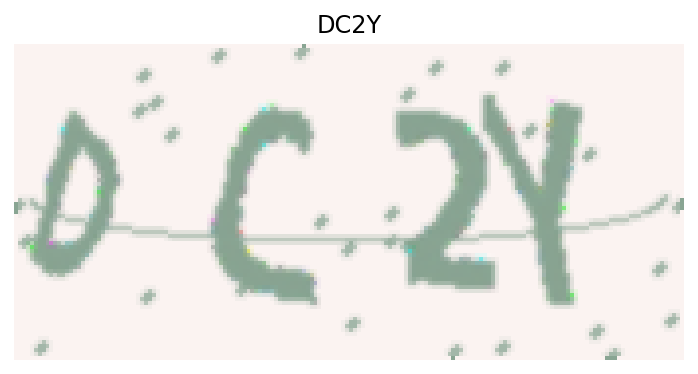

In [3]:
# 設定產生圖片的尺寸以及總類別, 其中 n_class+1 是為了留位置給 Blank
width, height, n_len, n_class = 170, 80, 4, len(characters)+1

# 設定產生驗證碼的generator
generator = ImageCaptcha(width=width, height=height)

# 先練習長度固定為四個字的驗證碼
random_str = ''.join([random.choice(characters) for j in range(4)])
img = generator.generate_image(random_str)

plt.imshow(img)
plt.title(random_str)
plt.axis('off');

## 自己搭建一個CNN模型使得output feature Map 高度被壓縮成小於4，8<寬度<20
#### 解答的output feature Map 為 (batch_size,1,13,32)

In [4]:
# CTC loss 需要 4 個資訊, Label, 預測, CNN輸出寬度, 預測影像所包含的文字長度
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

> keras.backend.ctc_batch_cost 與 tf.nn.ctc_loss 差別請參考 https://www.pythonf.cn/read/33377

In [5]:
rnn_size = 128

input_tensor = keras.layers.Input((height, width, 3))
x = keras.layers.Conv2D(32, (3, 3), activation='relu')(input_tensor)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D()(x)
x = keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D()(x)
x = keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D()(x)
x = keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D((2, 1))(x)

# 紀錄CNN輸出的尺寸以供loss部份使用
conv_shape = x.get_shape()

# 從(Batch_size, 輸出高度, 輸出寬度, 輸出深度)變成(Batch_size, 輸出寬度, 輸出深度*輸出高度)，以符合ctc loss需求
x = keras.layers.Reshape(target_shape=(int(conv_shape[2]), int(conv_shape[1]*conv_shape[3])))(x)

x = keras.layers.Dense(32, activation='relu')(x)
x = keras.layers.Dropout(0.25)(x)
x = keras.layers.Dense(n_class, activation='softmax')(x)

# 包裝用來預測的model
base_model = keras.Model(inputs=input_tensor, outputs=x)


# 設定要給 CTC Loss 的資訊
labels = keras.layers.Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = keras.layers.Input(name='input_length', shape=[1], dtype='int64')
label_length = keras.layers.Input(name='label_length', shape=[1], dtype='int64')
loss_out = keras.layers.Lambda(ctc_lambda_func, output_shape=(1, ), 
                               name='ctc')([x, labels, input_length, label_length])
# 這個 model 是用來計算 loss 的
model = keras.Model(inputs=[input_tensor, labels, input_length, label_length], outputs=[loss_out])
# 之所以要 lambda y_true, y_pred: y_pred 是因為我們的loss已經包在網路裡，會 output:y_true, y_pred，而我們只需要y_pred
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='SGD')

In [6]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 170, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 78, 168, 32)  896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 78, 168, 32)  128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 76, 166, 32)  9248        batch_normalization[0][0]        
____________________________________________________________________________________________

In [7]:
# 設計generator產生training data
# 產生包含要給loss的資訊
# X=輸入影像
# np.ones(batch_size)*int(conv_shape[2]) = CNN輸出feature Map寬度
# np.ones(batch_size)*n_len = 字串長度(可浮動)
def gen(batch_size=128):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = np.zeros((batch_size, n_len), dtype=np.uint8)
    while True:
        generator = ImageCaptcha(width=width, height=height)
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = np.array(generator.generate_image(random_str))
            y[i] = [characters.find(x) for x in random_str]
        yield [X, y, np.ones(batch_size)*int(conv_shape[2]), np.ones(batch_size)*n_len], np.ones(batch_size)

Label:  [[13 34 31 28]]
CNN輸出寬度:  [13.]
字串長度(可浮動):  [4.]


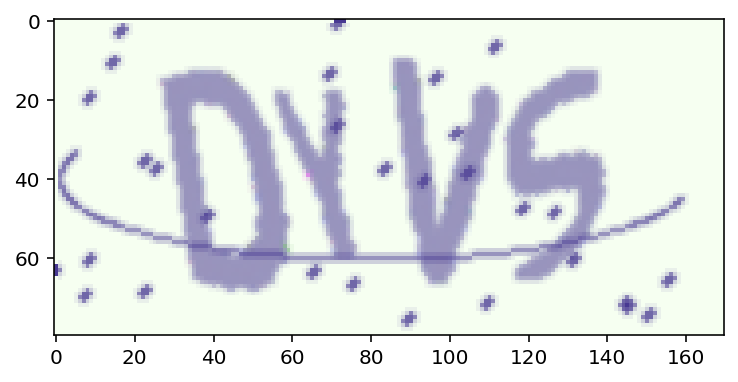

In [8]:
next_ge = gen(batch_size=1)
test_ge = next(next_ge)
plt.imshow(test_ge[0][0][0])
print('Label: ',test_ge[0][1])
print('CNN輸出寬度: ',test_ge[0][2])
print('字串長度(可浮動): ',test_ge[0][3])

## 開始訓練

In [9]:
model.fit(gen(32), steps_per_epoch=300, epochs=60)

  ...
    to  
  ['...']
Train for 300 steps
Epoch 1/60
300/300 [==============================] - 38s 126ms/step - loss: 15.5424
Epoch 2/60
300/300 [==============================] - 38s 125ms/step - loss: 12.2941
Epoch 3/60
300/300 [==============================] - 37s 123ms/step - loss: 8.5202
Epoch 4/60
300/300 [==============================] - 37s 124ms/step - loss: 6.3712
Epoch 5/60
300/300 [==============================] - 37s 122ms/step - loss: 5.1755
Epoch 6/60
300/300 [==============================] - 37s 123ms/step - loss: 4.4185
Epoch 7/60
300/300 [==============================] - 37s 122ms/step - loss: 4.0204
Epoch 8/60
300/300 [==============================] - 37s 122ms/step - loss: 3.6775
Epoch 9/60
300/300 [==============================] - 37s 122ms/step - loss: 3.4580
Epoch 10/60
300/300 [==============================] - 37s 122ms/step - loss: 3.2517
Epoch 11/60
300/300 [==============================] - 37s 123ms/step - loss: 3.1816
Epoch 12/60
300/300 [======

## 預測

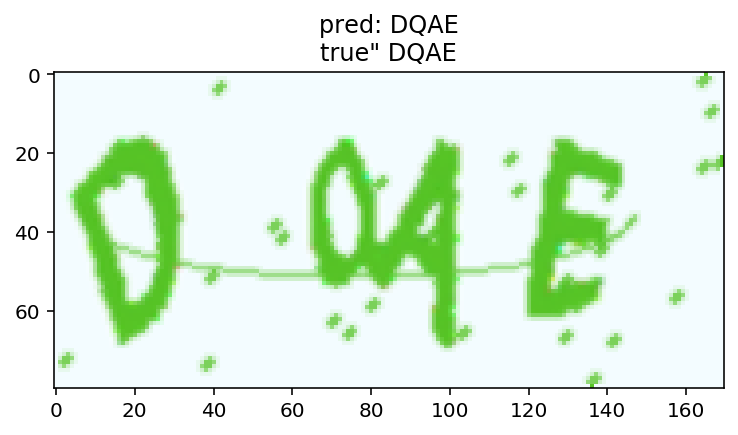

In [13]:
characters2 = characters + ' '
[X_test, y_test, _, _], _ = next(gen(1))
y_pred = base_model.predict(X_test)
# 用ctc_decode得到解答
out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])
out = ''.join([characters[x] for x in out[0]])
y_true = ''.join([characters[x] for x in y_test[0]])

plt.imshow(X_test[0])
plt.title('pred: ' + str(out) + '\ntrue" ' + str(y_true))
argmax = np.argmax(y_pred, axis=2)[0]

## 自己寫 decode CTC

In [14]:
## 其中0代表預測為空格，如果預測相同字符之間沒有空格要移除
word=''
n=''
for single_result in y_pred[0].argmax(1):
    if single_result != 36:
        if n != single_result:
            word+=characters[single_result]
    n=single_result 

In [17]:
word

'DQAE'

## 額外參考：加入RNN的神經網路

In [37]:
from keras.models import *
from keras.layers import *
rnn_size = 128

input_tensor = Input((height,width, 3))
x = input_tensor
for i in range(4):
    x = Convolution2D(32, 3, 3, activation='relu')(x)
    x = keras.layers.BatchNormalization(axis=-1)(x)
    x = Convolution2D(32, 3, 3, activation='relu')(x)
    x = keras.layers.BatchNormalization(axis=-1)(x)
    if i <3:
        x = MaxPooling2D(pool_size=(2, 2))(x)
    else:
        x = MaxPooling2D(pool_size=(2, 1))(x)


conv_shape = x.get_shape()
x = Reshape(target_shape=(int(conv_shape[2]), int(conv_shape[1]*conv_shape[3])))(x)

x = Dense(32, activation='relu')(x)

gru_1 = GRU(rnn_size, return_sequences=True, init='he_normal', name='gru1')(x)
gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, 
             init='he_normal', name='gru1_b')(x)
gru1_merged = keras.layers.add([gru_1, gru_1b])

gru_2 = GRU(rnn_size, return_sequences=True, init='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, 
             init='he_normal', name='gru2_b')(gru1_merged)
x = keras.layers.Concatenate()([gru_2, gru_2b])

x = Dropout(0.25)(x)
x = Dense(n_class, init='he_normal', activation='softmax')(x)

base_model = Model(input=input_tensor, output=x)

labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), 
                  name='ctc')([x, labels, input_length, label_length])

model = Model(input=[input_tensor, labels, input_length, label_length], output=[loss_out])
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='Adam')

/Users/chening/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  
/Users/chening/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  # Remove the CWD from sys.path while we load stuff.
/Users/chening/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, return_sequences=True, name="gru1", kernel_initializer="he_normal")`
/Users/chening/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, return_sequences=True, go_backwards=True, name="gru1_b", kernel_initializer="he_normal")`
/Users/chening/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU

In [38]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 80, 170, 3)   0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 78, 168, 32)  896         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, 78, 168, 32)  128         conv2d_25[0][0]                  
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 76, 166, 32)  9248        batch_normalization_25[0][0]     
__________________________________________________________________________________________________
batch_norm